## This is notebook exploring camera calibration challenge 
 - If you want to use the baseline model provided in the repo, you need to install all the libraries. 
 - I work in conda and created a soccernet environment where I installed the necessary versions of torch, etc. 
 - The notebook mostly follows the baseline code provided in the official repo with some additional graphics the explain what's going on. 

In [1]:
# To download the data you can run this cell. 
# from SoccerNet.Downloader import SoccerNetDownloader
# mySoccerNetDownloader = SoccerNetDownloader(LocalDirectory="")
# mySoccerNetDownloader.downloadDataTask(task="calibration", split=["train","valid","test","challenge"])
# Unzip the data after download in the calibration folder

In [2]:
import copy
import json
import os.path
import random
from collections import deque
from pathlib import Path

import cv2 as cv
import numpy as np
import torch
import torch.backends.cudnn
import torch.nn as nn
from PIL import Image
from torchvision.models.segmentation import deeplabv3_resnet50
from tqdm import tqdm

from src.soccerpitch import SoccerPitch
from src.baseline_extremities import (generate_class_synthesis, join_points, get_line_extremities, get_support_center, synthesize_mask)
from src.baseline_extremities import SegmentationNetwork
%matplotlib inline
from matplotlib import pyplot as plt
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook

In [3]:
lines_palette = [0, 0, 0]
for line_class in SoccerPitch.lines_classes:
    lines_palette.extend(SoccerPitch.palette[line_class])

In [4]:
# This is the image segmentation network provided in the repo. 
calib_net = SegmentationNetwork(
    "resources/soccer_pitch_segmentation.pth",
    "resources/mean.npy",
    "resources/std.npy")

In [5]:
dataset_dir = os.path.join('calibration', 'valid')
frames = [f for f in os.listdir(dataset_dir) if ".jpg" in f]
output_prediction_folder = os.path.join('results', 'valid')
if not os.path.exists(output_prediction_folder):
    os.makedirs(output_prediction_folder)

In [6]:
# You can choose a different image from the data. I'll use frame_index throughout the whole notebook
frame_index_int = 1

frame = frames[frame_index_int]
prediction = dict()
count = 0
frame_path = os.path.join(dataset_dir, frame)
frame_index = frame.split(".")[0]
image = cv.imread(frame_path)
print(image.shape)

(540, 960, 3)


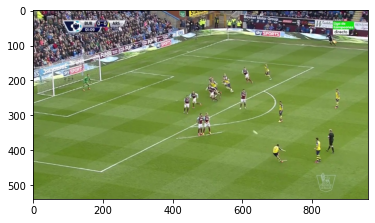

In [7]:
#Show the image with matplotlib
# This is the image for which we'll be trying to find field lines and camera calibration
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.show()

In [10]:
# This command finds the segmented field lines. 
semlines = calib_net.analyse_image(image)
# The network returns an image dimension(360, 640), with values from 0..25. Each int value corresponds to the particular field line
semlines.shape, semlines.dtype, np.unique(semlines)

((360, 640),
 dtype('uint8'),
 array([ 0,  1,  2,  3,  8, 10, 11, 12, 20, 22, 23, 24, 25], dtype=uint8))

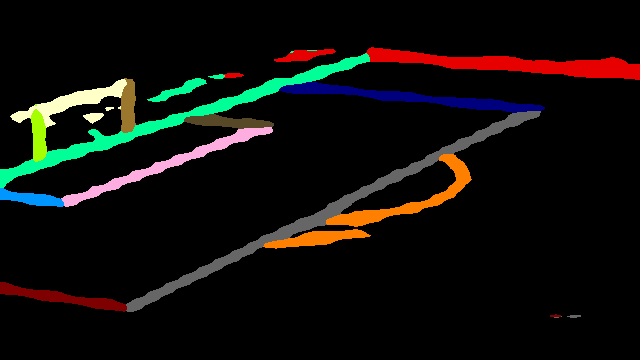

In [11]:
#Assigning each field line a separate color based on the palette provided in the code. 
mask = Image.fromarray(semlines.astype(np.uint8)).convert('P')
mask.putpalette(lines_palette)
mask_file = os.path.join(output_prediction_folder, frame_index + '.png')
mask.save(mask_file) # if you want to save file
mask

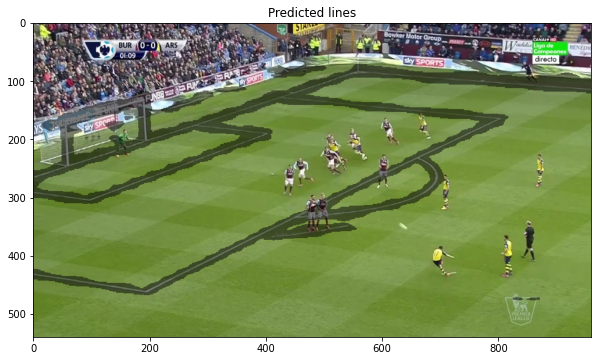

In [12]:
# Overlay the mask with the image
image_bkg = cv.cvtColor(image, cv.COLOR_BGR2RGB)
field_lines = cv.resize(semlines, (image.shape[1], image.shape[0]))
field_lines[field_lines>0] = 125
image_bkg[field_lines>0] = image_bkg[field_lines>0]//2
#Show the image with matplotlib
plt.figure(figsize= (10,15))
plt.title('Predicted lines')
plt.imshow(image_bkg)
plt.show()
# As we can see some mistakes include other lines(not field lines) included in one of the categories. ---> Area to improve

 - Next we have some code that uses the segmentation data to find line extremities. 
 - All the code is taken from the baseline in the repo. 
 - We do not need to use it to find extremities but it's a good starting point. 

In [13]:
skeletons = generate_class_synthesis(semlines, 6)

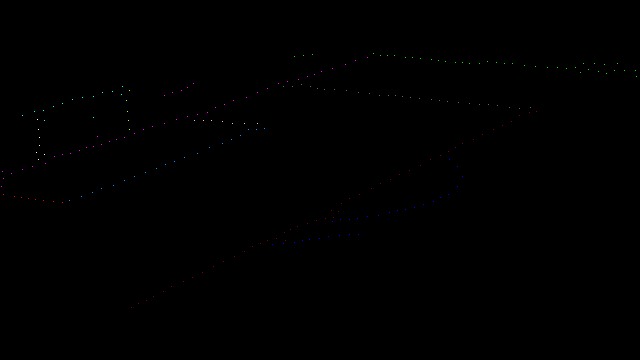

In [14]:
# Visualize skeletons.
skeletons_vis = np.zeros(semlines.shape).astype('uint8')
for k, class_name in enumerate(SoccerPitch.lines_classes):
    if class_name in skeletons.keys():
        for xy in skeletons[class_name]:
            skeletons_vis[xy[0], xy[1]] = k

skeletons_vis = Image.fromarray(skeletons_vis).convert('P')
skeletons_vis.putpalette(lines_palette)
skeletons_vis

In [15]:
resolution_width = 640
resolution_height = 360
extremities = get_line_extremities(skeletons, 40, resolution_width, resolution_height)

In [16]:
extremities

{'Big rect. left bottom': [{'x': 0.1953125, 'y': 0.8527777777777777},
  {'x': 0.00625, 'y': 0.8}],
 'Big rect. left main': [{'x': 0.8375, 'y': 0.30833333333333335},
  {'x': 0.2046875, 'y': 0.8527777777777777}],
 'Big rect. left top': [{'x': 0.4421875, 'y': 0.2388888888888889},
  {'x': 0.828125, 'y': 0.2972222222222222}],
 'Circle left': [{'x': 0.7015625, 'y': 0.44166666666666665},
  {'x': 0.425, 'y': 0.6777777777777778}],
 'Goal left crossbar': [{'x': 0.190625, 'y': 0.2388888888888889},
  {'x': 0.06875, 'y': 0.3333333333333333}],
 'Goal left post left ': [{'x': 0.0578125, 'y': 0.33055555555555555},
  {'x': 0.06875, 'y': 0.42777777777777776}],
 'Goal left post right': [{'x': 0.2015625, 'y': 0.25},
  {'x': 0.2015625, 'y': 0.35833333333333334}],
 'Side line left': [{'x': 0.0015625, 'y': 0.5166666666666667},
  {'x': 0.5734375, 'y': 0.15833333333333333}],
 'Side line top': [{'x': 0.94375, 'y': 0.17777777777777778},
  {'x': 0.5828125, 'y': 0.14722222222222223}],
 'Small rect. left bottom': [

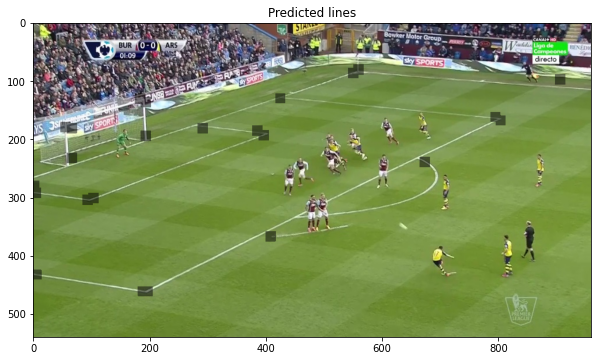

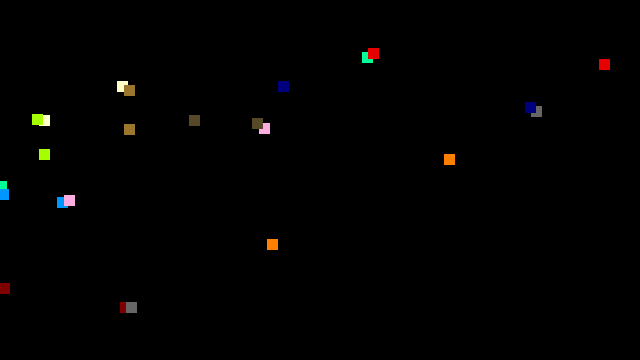

In [17]:
# Visualize extremities. Mark each point with a square of size 2*w + 1 and overlay over main image

w = 5
extremities_vis = np.zeros(semlines.shape).astype('uint8')
for k, class_name in enumerate(SoccerPitch.lines_classes):
    if class_name in extremities.keys():
        for xy in extremities[class_name]:
            y = int(xy['y']*resolution_height)
            x = int(xy['x']*resolution_width)
            extremities_vis[max(y-w,0):min(y+w+1,resolution_height-1), max(x-w,0):min(x+w+1,resolution_width-1) ] = k+1

           
image_bkg = cv.cvtColor(image, cv.COLOR_BGR2RGB)
extremities_overlay = cv.resize(extremities_vis, (image.shape[1], image.shape[0]))
extremities_overlay[extremities_overlay>0] = 125
image_bkg[extremities_overlay>0] = image_bkg[extremities_overlay>0]//2
#Show the image with matplotlib
plt.figure(figsize= (10,15))
plt.title('Predicted lines')
plt.imshow(image_bkg)
plt.show()
            
            
            
extremities_vis = Image.fromarray(extremities_vis).convert('P')
extremities_vis.putpalette(lines_palette)
extremities_vis

In [18]:
prediction_file = os.path.join(output_prediction_folder, f"extremities_{frame_index}.json")
with open(prediction_file, "w") as f:
    json.dump(extremities, f, indent=4)

### Evaluation
 - This is part 1 of the challenge. 
 - You get evaluated on how accurate are your extremities calculations

In [19]:
from src.evaluate_extremities import distance, \
                                     mirror_labels, \
                                     evaluate_detection_prediction, \
                                     scale_points # Scale dictionary of points from {0...1} to {res_width, res_height}  
#params
threshold = 10

In [20]:
output_prediction_folder, dataset_dir, frame_index, frame_index_int

('results\\valid', 'calibration\\valid', '00001', 1)

In [21]:
annotation_files = [f for f in os.listdir(dataset_dir) if ".json" in f]

In [22]:
annotation_file = os.path.join(dataset_dir, annotation_files[frame_index_int])
prediction_file = os.path.join(output_prediction_folder,  f"extremities_{frame_index}.json")

with open(annotation_file, 'r') as f:
    line_annotations = json.load(f)

with open(prediction_file, 'r') as f:
    predictions = json.load(f)


In [23]:
print(f'Resolution width = {resolution_width}. Resolution_height = {resolution_height}')
predictions = scale_points(predictions, resolution_width, resolution_height)
line_annotations = scale_points(line_annotations, resolution_width, resolution_height)
img_prediction = predictions
img_groundtruth = line_annotations

Resolution width = 640. Resolution_height = 360


In [24]:
# Let's look at examples. Not the extremities can be in random order. The evaluate function takes care of that. 
schema_part = 'Big rect. left bottom'
print(f"{schema_part}.\nPrediction = {img_prediction[schema_part]}.\nTruth      = {img_groundtruth[schema_part]}.")


Big rect. left bottom.
Prediction = [{'x': 125.0, 'y': 307.0}, {'x': 4.0, 'y': 288.0}].
Truth      = [{'x': 0.0, 'y': 288.489990234375}, {'x': 129.035005569458, 'y': 309.62000370025635}].


In [25]:
confusion1, per_class_conf1, reproj_errors1 = evaluate_detection_prediction(img_prediction,img_groundtruth, threshold)
confusion2, per_class_conf2, reproj_errors2 = evaluate_detection_prediction(img_prediction, mirror_labels(img_groundtruth),threshold)
accuracy1, accuracy2 = 0., 0.
if confusion1.sum() > 0:
    accuracy1 = confusion1[0, 0] / confusion1.sum()

if confusion2.sum() > 0:
    accuracy2 = confusion2[0, 0] / confusion2.sum()

if accuracy1 > accuracy2:
    accuracy = accuracy1
    confusion = confusion1
    per_class_conf = per_class_conf1
    reproj_errors = reproj_errors1
else:
    accuracy = accuracy2
    confusion = confusion2
    per_class_conf = per_class_conf2
    reproj_errors = reproj_errors2

precision = confusion[0, 0] / (confusion[0, :].sum())
recall = confusion[0, 0] / (confusion[0, 0] + confusion[1, 0])

In [26]:
print(f'accuracy = {accuracy}, precision = {precision}, recall = {recall}')
print(f'confusion = \n{confusion}')
for key, value in reproj_errors.items():
    print(key, ':', np.around(value,1))

accuracy = 0.7916666865348816, precision = 0.7916666865348816, recall = 1.0
confusion = 
[[19.  5.]
 [ 0.  0.]]
Goal left crossbar : [10.4  4.9]
Small rect. left top : [13.   8.6]
Big rect. left top : [3.9 3.6]
Circle left : [36.7  9.8]
Side line left : [7.2 8.1]
Small rect. left bottom : [1.4 3.7]
Big rect. left main : [4.4 3.7]
Small rect. left main : [5.5 3.2]
Goal left post right : [2.1 5.1]
Side line top : [ 1.2 38.3]
Big rect. left bottom : [4.  4.8]
Goal left post left  : [ 6.9 11.1]


In [27]:
reproj_errors

{'Goal left crossbar': [10.36695353211883, 4.922323125826503],
 'Small rect. left top': [12.981437290100525, 8.61029327957612],
 'Big rect. left top': [3.883180929036408, 3.6351453804612],
 'Circle left': [36.69974410077125, 9.75471399094641],
 'Side line left': [7.169599139751266, 8.092029987435819],
 'Small rect. left bottom': [1.392488729501688, 3.6617648808965026],
 'Big rect. left main': [4.448424506936261, 3.6985716310232246],
 'Small rect. left main': [5.506632685250285, 3.206950119978865],
 'Goal left post right': [2.135518258559022, 5.085122434670297],
 'Side line top': [1.1719414014447194, 38.3437067873839],
 'Big rect. left bottom': [4.029899555793279, 4.810996709094083],
 'Goal left post left ': [6.929742804893593, 11.05140874584479]}

## Homography

 - Second part of the challenge 
 - Based on the image and extremities find camera parameters
 - Current baseline implementation only uses the extremities file to find camera calibration. We do not need to use only that. We could use other extracted information from the image. 

In [28]:
from src.camera import Camera
from src.soccerpitch import SoccerPitch
from src.baseline_cameras import normalization_transform #Computes the similarity transform such that the list of points is centered around (0,0) and that its distance to thecenter is sqrt(2).
from src.baseline_cameras import estimate_homography_from_line_correspondences
from src.baseline_cameras import draw_pitch_homography

In [29]:
prediction_file = os.path.join(output_prediction_folder,  f"extremities_{frame_index}.json")
output_prediction_folder, dataset_dir, frame_index, frame_index_int,prediction_file, resolution_width, resolution_height

('results\\valid',
 'calibration\\valid',
 '00001',
 1,
 'results\\valid\\extremities_00001.json',
 640,
 360)

In [30]:
with open(prediction_file, 'r') as f:
    predictions = json.load(f)
camera_predictions = dict()
image_path = os.path.join(dataset_dir, frame)
cv_image = cv.imread(image_path)
cv_image = cv.resize(cv_image, (resolution_width, resolution_height))

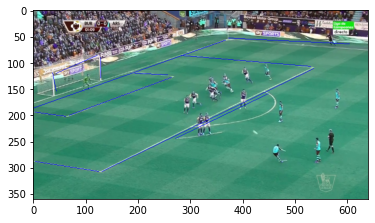

In [31]:
field = SoccerPitch()
line_matches = []
potential_3d_2d_matches = {}
src_pts = []
success = False
# For each prediction we attempt to find the corresponding line in the filed pitch schema. 
# Since we don't know which point in extremities is which end of the line, some points can have potential multiple matches
# You can uncomment some print statements to explore the loop

for k, v in predictions.items():
    if k == 'Circle central' or "unknown" in k:
        continue
    P3D1 = field.line_extremities_keys[k][0] # Dict key names of 
    P3D2 = field.line_extremities_keys[k][1]   
    
    p1 = np.array([v[0]['x'] * resolution_width, v[0]['y'] * resolution_height, 1.]) #line extremities
    p2 = np.array([v[1]['x'] * resolution_width, v[1]['y'] * resolution_height, 1.])
    #print(f'{k} ----  {P3D1}:{p1}.  {P3D2}:{p2}')        
    src_pts.extend([p1, p2])
    if P3D1 in potential_3d_2d_matches.keys():
        potential_3d_2d_matches[P3D1].extend([p1, p2])
    else:
        potential_3d_2d_matches[P3D1] = [p1, p2]
    if P3D2 in potential_3d_2d_matches.keys():
        potential_3d_2d_matches[P3D2].extend([p1, p2])
    else:
        potential_3d_2d_matches[P3D2] = [p1, p2]

    start = (int(p1[0]), int(p1[1]))
    end = (int(p2[0]), int(p2[1]))
    cv.line(cv_image, start, end, (0, 0, 255), 1)

    line = np.cross(p1, p2)
    if np.isnan(np.sum(line)) or np.isinf(np.sum(line)):
        continue
    line_pitch = field.get_2d_homogeneous_line(k) #line_pitch is the line on the field 2D coordinates. Excludes circle and goal posts
    if line_pitch is not None:
        line_matches.append((line_pitch, line))
        
#for k, v in potential_3d_2d_matches.items():
#    print(k,':', v)
    
plt.imshow(cv_image)

In [48]:
if len(line_matches) >= 4:
    target_pts = [field.point_dict[k][:2] for k in potential_3d_2d_matches.keys()]
    T1 = normalization_transform(target_pts)
    T2 = normalization_transform(src_pts)
    success, homography = estimate_homography_from_line_correspondences(line_matches, T1, T2)
    if success:
        #cv_image = draw_pitch_homography(cv_image, homography)
        cam = Camera(resolution_width, resolution_height)      
        success = cam.from_homography(homography)
        if success:
            print('Succesfully estimate homography. First approximation camera parameters...')
            for k,v in cam.to_json_parameters().items():
                print(k,':', v)
            point_matches = []
            added_pts = set()
            for k, potential_matches in potential_3d_2d_matches.items():
                p3D = field.point_dict[k]
                projected = cam.project_point(p3D)

                if 0 < projected[0] < resolution_width and 0 < projected[1] < resolution_height:
                    dist = np.zeros(len(potential_matches))
                    for i, potential_match in enumerate(potential_matches):
                        dist[i] = np.sqrt((projected[0] - potential_match[0]) ** 2 + (
                                projected[1] - potential_match[1]) ** 2)
                    selected = np.argmin(dist)
                    if dist[selected] < 100:
                        point_matches.append((p3D, potential_matches[selected][:2]))

            if len(point_matches) > 3:
                print('\n\nFound > 3 point matches. Refining homography. New camera parameters are... ')
                cam.refine_camera(point_matches)
                for k,v in cam.to_json_parameters().items():
                    print(k,':', v)                
                cam.draw_colorful_pitch(cv_image, SoccerPitch.palette)
                print(image_path)
                # cv.imshow("colorful pitch", cv_image)
                # cv.waitKey(0)

if success:
    camera_predictions = cam.to_json_parameters()

task2_prediction_file = os.path.join(output_prediction_folder, f"camera_{frame_index}.json")
if camera_predictions:
    with open(task2_prediction_file, "w") as f:
        json.dump(camera_predictions, f, indent=4)

Succesfully estimate homography. First approximation camera parameters...
pan_degrees : -34.383422784524086
tilt_degrees : 76.56384974035171
roll_degrees : 3.842849219934099
position_meters : [0.31612520412752315, 61.389888671628796, -18.21842980519313]
x_focal_length : 1699.879155303339
y_focal_length : 1699.8791553033166
principal_point : [320.0, 180.0]
radial_distortion : [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
tangential_distortion : [0.0, 0.0]
thin_prism_distortion : [0.0, 0.0, 0.0, 0.0]


Found > 3 point matches. Refining homography. New camera parameters are... 
pan_degrees : -30.192819546294484
tilt_degrees : 74.85178751042864
roll_degrees : 0.46990223107884216
position_meters : [2.8563365690169813, 71.3949753314836, -22.6636116835998]
x_focal_length : 1699.879155303339
y_focal_length : 1699.8791553033166
principal_point : [320.0, 180.0]
radial_distortion : [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
tangential_distortion : [0.0, 0.0]
thin_prism_distortion : [0.0, 0.0, 0.0, 0.0]
calibration\valid\00

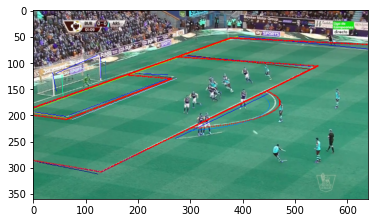

In [39]:
#Initial estimation of homography  based on line correspondences
plt.imshow(draw_pitch_homography(cv_image, homography))

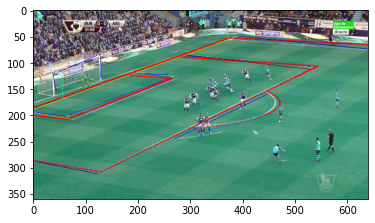

In [41]:
#Refined estimation of homography  based on line correspondences
plt.imshow(cam.draw_colorful_pitch(cv_image, SoccerPitch.palette))

# Finally let's take a look at how camera evaluation is done

In [ ]:
accuracies = []
precisions = []
recalls = []
dict_errors = {}
per_class_confusion_dict = {}


In [49]:
dataset_dir

'calibration\\valid'

In [ ]:

    dataset_dir = os.path.join(args.soccernet, args.split)
    if not os.path.exists(dataset_dir):
        print("Invalid dataset path !")
        exit(-1)

    annotation_files = [f for f in os.listdir(dataset_dir) if ".json" in f]

    missed, total_frames = 0, 0
    with tqdm(enumerate(annotation_files), total=len(annotation_files), ncols=160) as t:
        for i, annotation_file in t:
            frame_index = annotation_file.split(".")[0]
            annotation_file = os.path.join(args.soccernet, args.split, annotation_file)
            prediction_file = os.path.join(args.prediction, args.split, f"camera_{frame_index}.json")

            total_frames += 1

            if not os.path.exists(prediction_file):
                missed += 1

                continue

            with open(annotation_file, 'r') as f:
                line_annotations = json.load(f)

            with open(prediction_file, 'r') as f:
                predictions = json.load(f)

            line_annotations = scale_points(line_annotations, args.resolution_width, args.resolution_height)

            image_path = os.path.join(args.soccernet, args.split, f"{frame_index}.jpg")

            img_groundtruth = line_annotations

            img_prediction = get_polylines(predictions, args.resolution_width, args.resolution_height,
                                           sampling_factor=0.9)

            confusion1, per_class_conf1, reproj_errors1 = evaluate_camera_prediction(img_prediction,
                                                                                     img_groundtruth,
                                                                                     args.threshold)

            confusion2, per_class_conf2, reproj_errors2 = evaluate_camera_prediction(img_prediction,
                                                                                     mirror_labels(img_groundtruth),
                                                                                     args.threshold)

            accuracy1, accuracy2 = 0., 0.
            if confusion1.sum() > 0:
                accuracy1 = confusion1[0, 0] / confusion1.sum()

            if confusion2.sum() > 0:
                accuracy2 = confusion2[0, 0] / confusion2.sum()

            if accuracy1 > accuracy2:
                accuracy = accuracy1
                confusion = confusion1
                per_class_conf = per_class_conf1
                reproj_errors = reproj_errors1
            else:
                accuracy = accuracy2
                confusion = confusion2
                per_class_conf = per_class_conf2
                reproj_errors = reproj_errors2

            accuracies.append(accuracy)
            if confusion[0, :].sum() > 0:
                precision = confusion[0, 0] / (confusion[0, :].sum())
                precisions.append(precision)
            if (confusion[0, 0] + confusion[1, 0]) > 0:
                recall = confusion[0, 0] / (confusion[0, 0] + confusion[1, 0])
                recalls.append(recall)

            for line_class, errors in reproj_errors.items():
                if line_class in dict_errors.keys():
                    dict_errors[line_class].extend(errors)
                else:
                    dict_errors[line_class] = errors

            for line_class, confusion_mat in per_class_conf.items():
                if line_class in per_class_confusion_dict.keys():
                    per_class_confusion_dict[line_class] += confusion_mat
                else:
                    per_class_confusion_dict[line_class] = confusion_mat